# Lab 6 : Image Segmentation

#Image Segmentation Using TensorFlow

In this notebook we will do image segmentation on the dataset "Oxford-3T Pet Dataset".
Dataset consists of **37** pet breeds with 200 images per breed.

Each image includes the correspondig labels and pixelwise masks. The masks are class-labels for each pixel and each pixel is given one of three categories:

    *  Class 1: Pixel belonging to pet
    *  Class 2: Pixel bordering the pet
    *  Class 3: None(surroundin pixel)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/2n UNI/3r Trimestre/Processament Imatges/Labs/Lab6/'

Mounted at /content/drive


##Check for Graphic Card

In [ ]:
!nvidia-smi

Sat Jun 22 16:26:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Getting the Helper Function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-22 16:26:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-22 16:26:39 (92.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

##Downloading the Oxford-3T Pets dataset

In [ ]:
#importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
#tfds.list_builders()

In [ ]:
#download the dataset
(train_data, test_data), ds_info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, split=['train', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

##Preprocessing of Data

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>)

In [ ]:
#infor
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpiyxh57sstfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

###Normalization & Loading

In [ ]:
#function for normalization
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/255.
  input_mask -= 1
  return input_image, input_mask


In [ ]:
#loadimages
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask  = tf.image.resize(datapoint['segmentation_mask'], (224,224))

  input_image, input_mask = normalize(input_image,
                                      input_mask)
  return input_image, input_mask

In [ ]:
#trainlen and batch size
TRAIN_LENGTH = ds_info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000


In [ ]:
TRAIN_LENGTH

3680

In [ ]:
train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>)

###Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=54):
    super().__init__()
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
#build the input pipeline
train_batches = (
    train_data
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
                 )

test_batches= test_data.batch(BATCH_SIZE)

##Visualize the data

In [ ]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15,15))

  title=['Input_Image', 'True_Mask', 'Predicted_Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

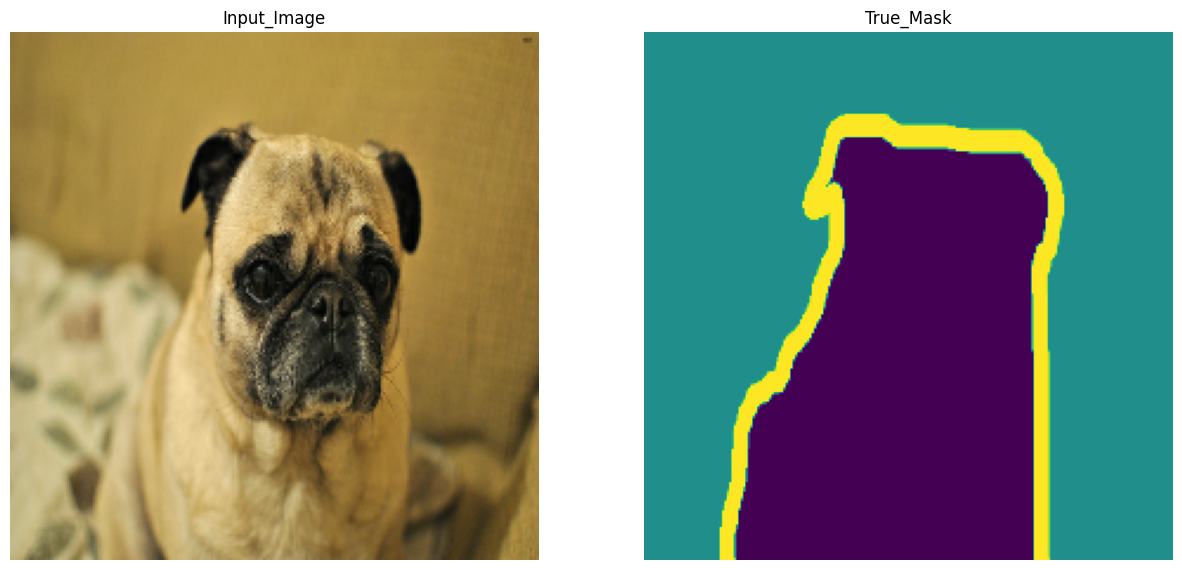

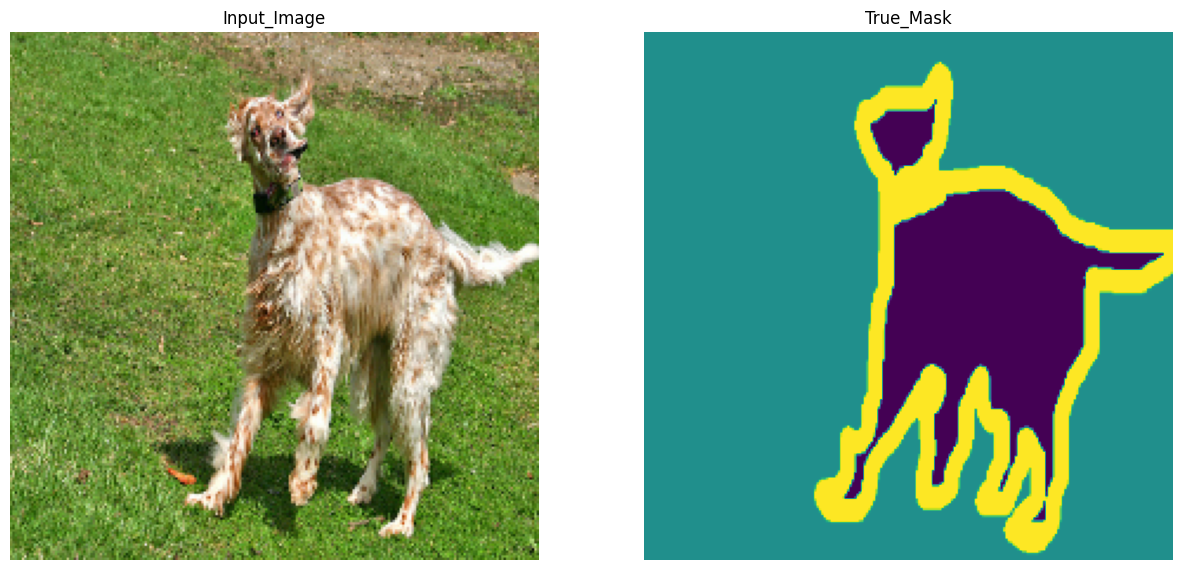

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[1], masks[1]
  display ([sample_image, sample_mask])

##Defining the Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               input_shape=[224,224,3])

layer_names = [
               'block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#Feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#Decoder/upsampler
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
up_stack =[
           pix2pix.upsample(512, 3),
           pix2pix.upsample(256, 3),
           pix2pix.upsample(128, 3),
           pix2pix.upsample(64, 3)
]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xh1aik2k
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-xh1aik2k
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=85757ad901044fd4b287053e01cd82b12bb9394b392fbf3400c0cb37ef85169c
  Stored in directory: /tmp/pip-ephem-wheel-cache-05ihixbg/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
#unet_model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224,224,3])
  #downsampling
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  #upsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  #last layer of model
  last = tf.keras.layers.Conv2DTranspose(
      filters = output_channels, kernel_size=3, strides=2,
      padding='same'
  )
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


##Train the model

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
output_classes=3
model = unet_model(output_channels=output_classes)
# model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule), metrics=['accuracy'])   # Exponencial Decay


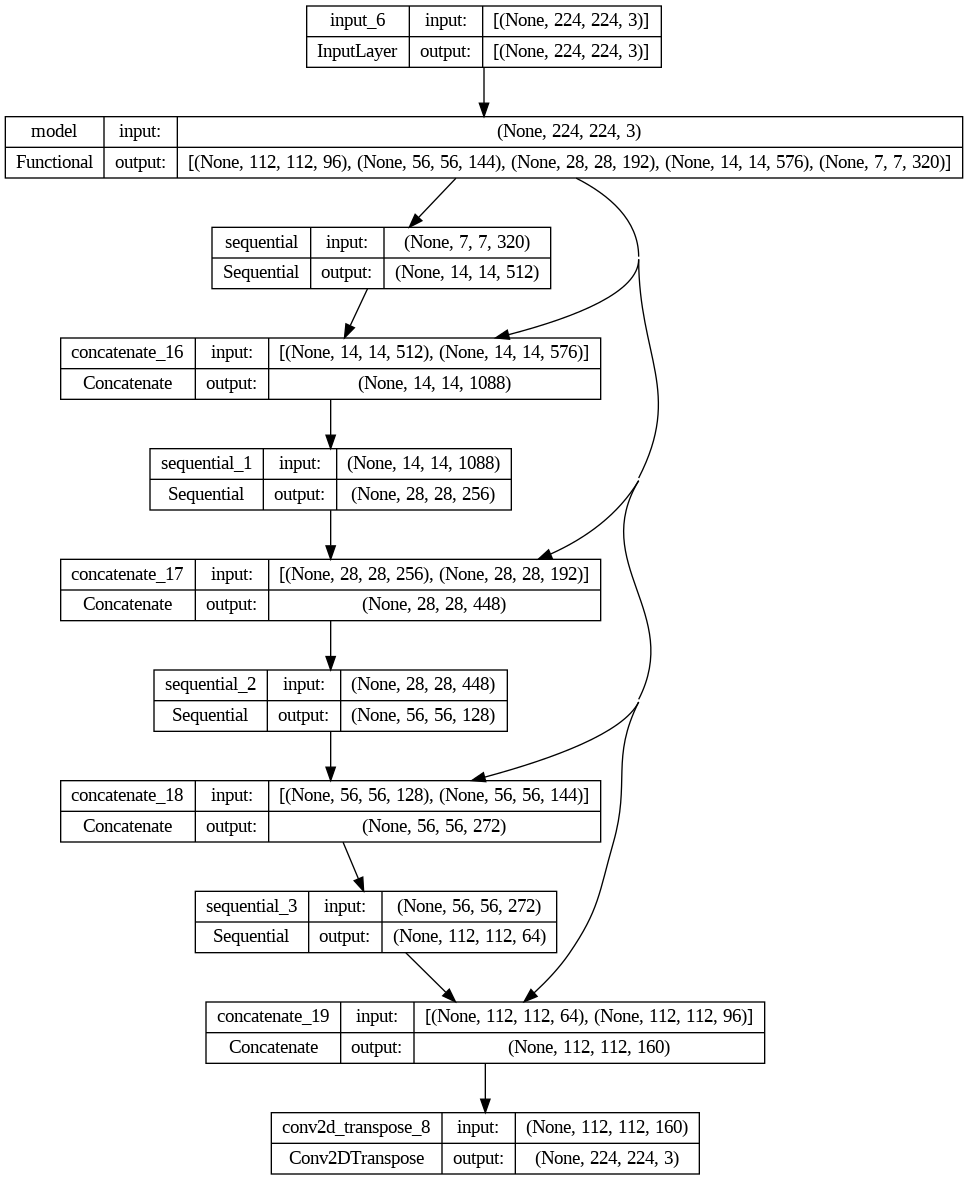

In [ ]:
# show the model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#fuctions for predictions
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


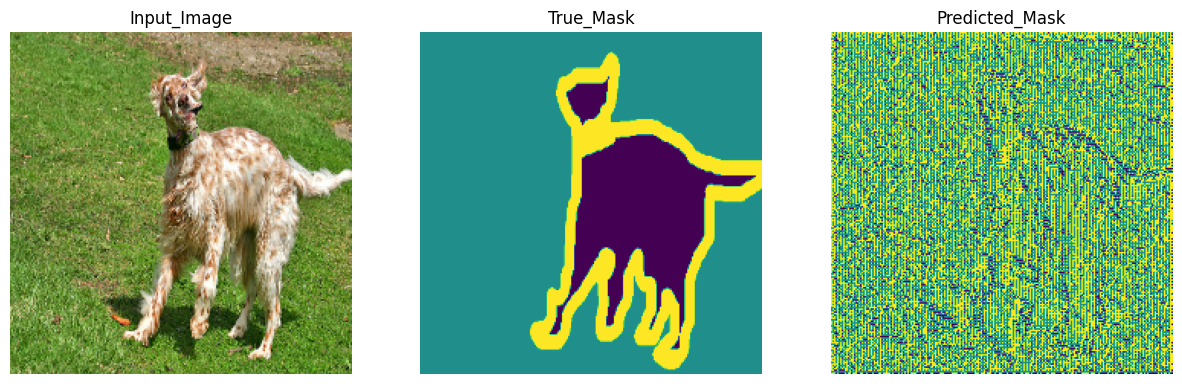

In [ ]:
#predictions before training
show_predictions()

In [ ]:
#Call back
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_prediction()
    print('\nsample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
model_history = model.fit(train_batches,
                          epochs = 5,
                          validation_data= test_batches,
                          validation_steps=int(0.15 * len(test_batches)),
                          steps_per_epoch = 115,
                          )

Epoch 1/5
115/115 [==============================] - 23s 199ms/step - loss: 0.3773 - accuracy: 0.8666 - val_loss: 0.3818 - val_accuracy: 0.8608
Epoch 2/5
115/115 [==============================] - 23s 197ms/step - loss: 0.3578 - accuracy: 0.8704 - val_loss: 0.3654 - val_accuracy: 0.8643
Epoch 3/5
115/115 [==============================] - 22s 193ms/step - loss: 0.3435 - accuracy: 0.8732 - val_loss: 0.3524 - val_accuracy: 0.8670
Epoch 4/5
115/115 [==============================] - 21s 186ms/step - loss: 0.3323 - accuracy: 0.8756 - val_loss: 0.3413 - val_accuracy: 0.8701
Epoch 5/5
115/115 [==============================] - 22s 196ms/step - loss: 0.3231 - accuracy: 0.8774 - val_loss: 0.3329 - val_accuracy: 0.8731


In [ ]:
results=model.evaluate(test_batches)

115/115 [==============================] - 13s 111ms/step - loss: 0.3322 - accuracy: 0.8924


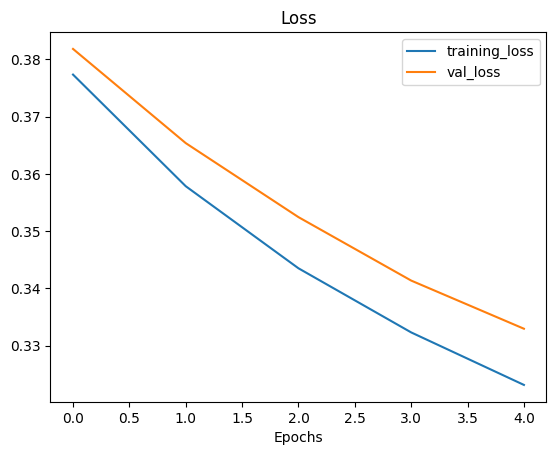

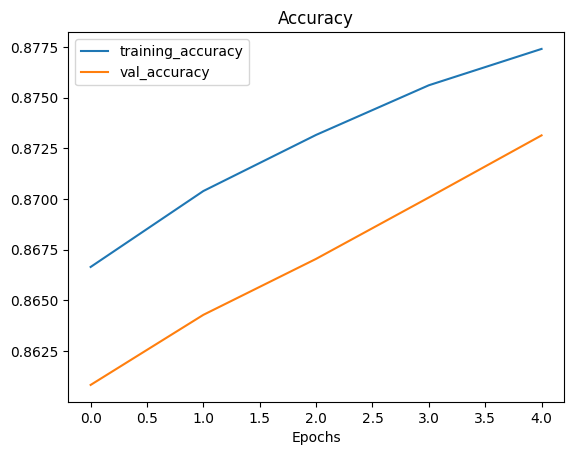

In [ ]:
plot_loss_curves(model_history)

1/1 [==============================] - 0s 130ms/step


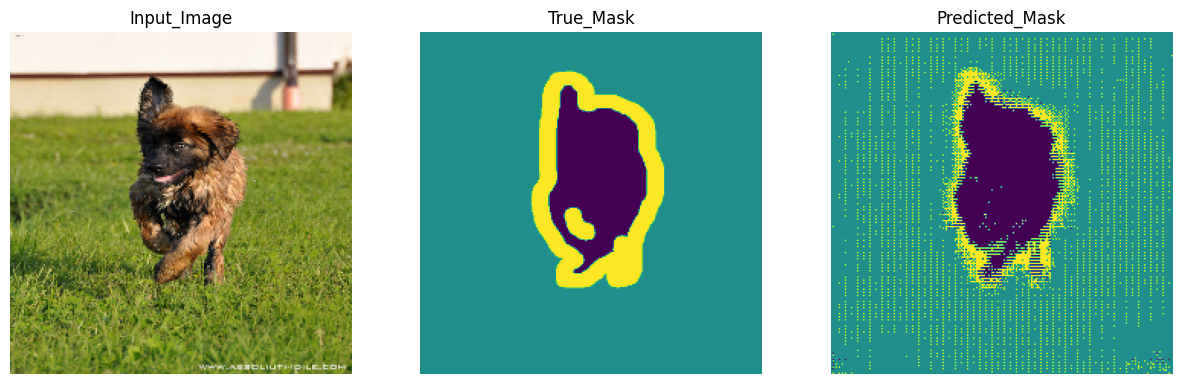

1/1 [==============================] - 0s 90ms/step


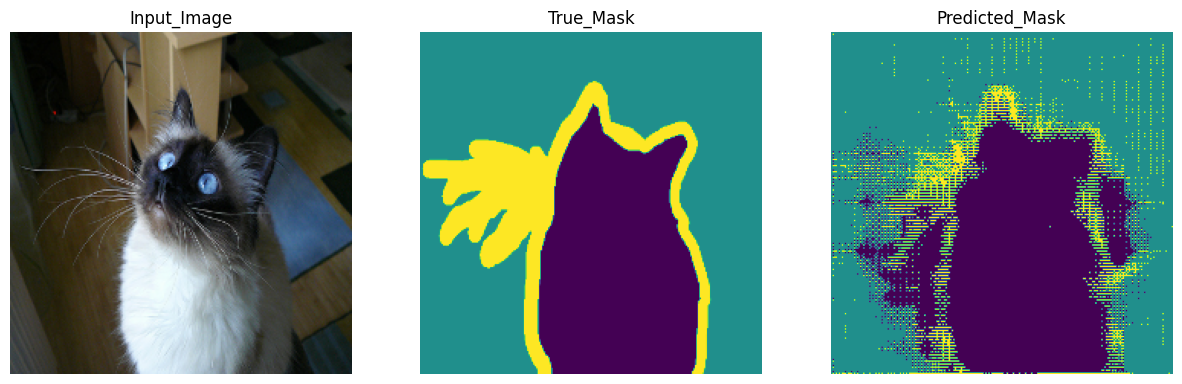

1/1 [==============================] - 0s 49ms/step


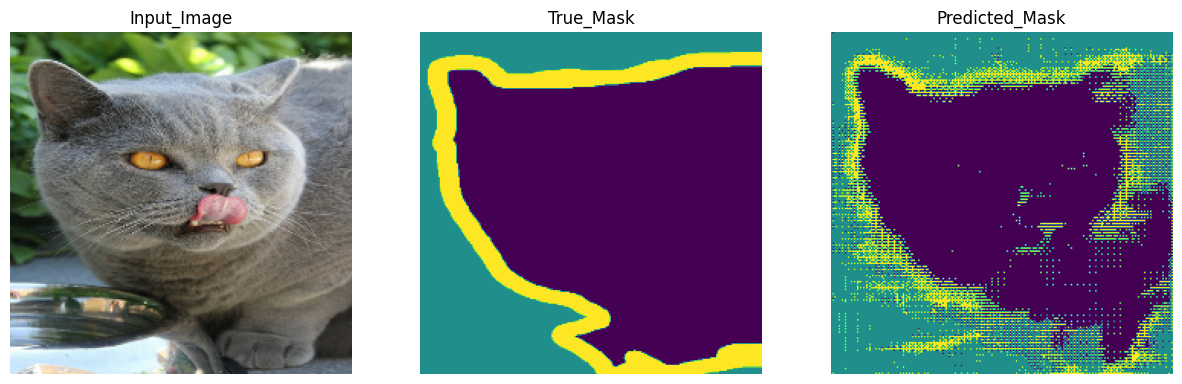

In [ ]:
show_predictions(test_batches, 3)

Test your Model now on any random Cat and Dog Image from the Internet !!!!!! Let's see how good our predictions can be :)

In [ ]:
img = plt.imread(path+"GatoSandia.jpg")
plt.imread(path+"GatoSandia.jpg")

array([[[ 17,  15,  18],
        [ 20,  18,  21],
        [ 18,  16,  19],
        ...,
        [ 79,  69,  44],
        [ 93,  86,  60],
        [102,  97,  68]],

       [[  8,   6,   9],
        [  7,   5,   8],
        [  8,   6,   9],
        ...,
        [ 76,  66,  41],
        [ 91,  84,  58],
        [106,  99,  71]],

       [[  9,   7,   8],
        [  5,   3,   4],
        [  7,   5,   6],
        ...,
        [ 76,  64,  38],
        [ 94,  84,  57],
        [110, 100,  73]],

       ...,

       [[117, 114,  97],
        [117, 114,  97],
        [115, 114,  96],
        ...,
        [187, 158, 118],
        [187, 158, 118],
        [186, 157, 117]],

       [[117, 114,  97],
        [116, 113,  96],
        [116, 113,  94],
        ...,
        [186, 157, 117],
        [185, 156, 116],
        [184, 155, 115]],

       [[117, 114,  97],
        [116, 113,  96],
        [116, 113,  94],
        ...,
        [186, 157, 117],
        [185, 156, 116],
        [184, 155, 115]]], dtype=uint8)

In [ ]:
img=tf.image.resize(img, (224,224))
img= tf.cast(img, tf.float32)
img=img/255.
img.shape

TensorShape([224, 224, 3])

In [ ]:
def pred(img):
  pred_mask=model.predict(tf.expand_dims(img, axis=0))
  display([img,  create_mask(pred_mask)])

1/1 [==============================] - 0s 23ms/step


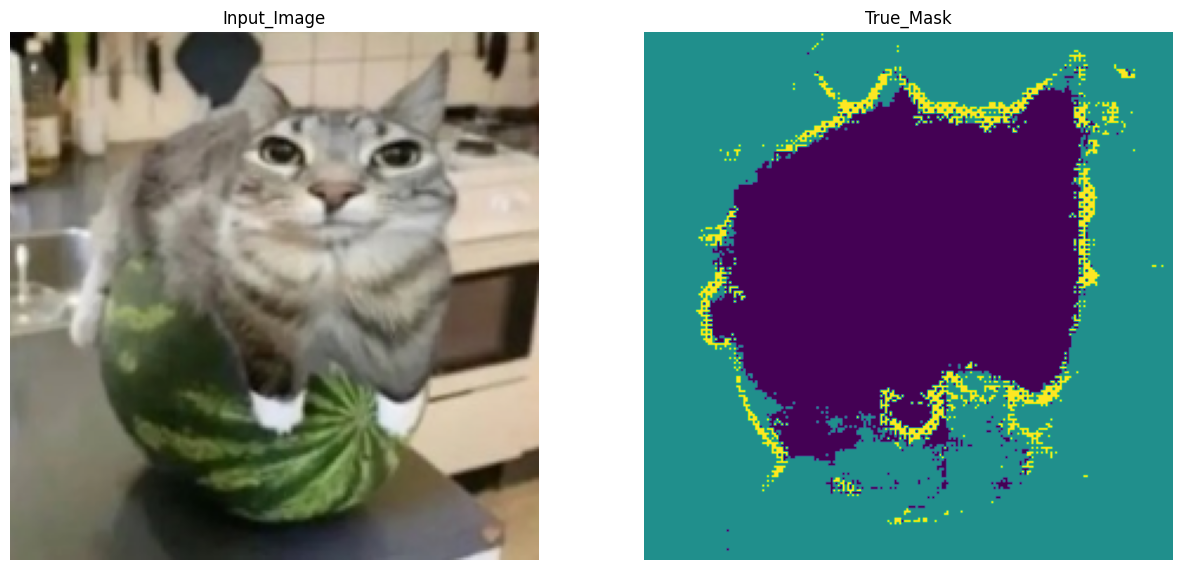

In [ ]:
pred(img)